# EDA 
This is basic EDA of the dataset. We generated some basic plots to better understand the data, which would make modelling easier. The specific visualizations are described in detail later in the notebook.

In [2]:
# required imports
import numpy as np 
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# # plotting imports
# import plotly.graph_objs as go
# import plotly.tools as tls
# from plotly.offline import iplot, init_notebook_mode
# import plotly.figure_factory as ff

# sklearn imports
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING

import os

In [3]:
# load datasets
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

# Visualizations
The first plot is a simple visualization of a basic distribution of data entries from each city. 

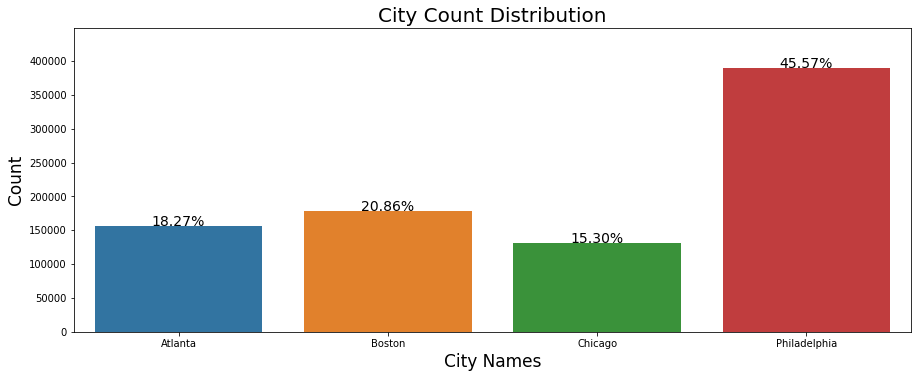

In [4]:
total = len(df_train)
plt.figure(figsize=(15,19))

plt.subplot(311)
g = sns.countplot(x="City", data=df_train)
g.set_title("City Count Distribution", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("City Names", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

The following visualization is to anaylze the traffic by hour in each city. This provides key insights into what times of the day traffic is the highest.

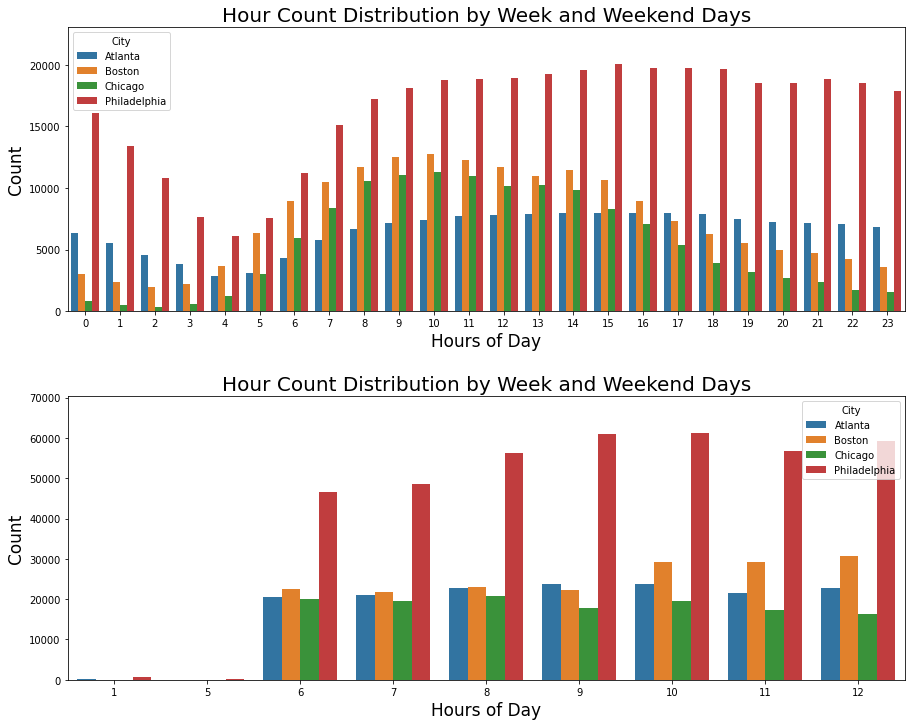

In [12]:
tmp_hour = df_train.groupby(['City', 'Hour'])['RowId'].nunique().reset_index()

plt.figure(figsize=(15,12))

plt.subplot(211)
g = sns.countplot(x="Hour", data=df_train, hue='City', dodge=True)
g.set_title("Hour Count Distribution by Week and Weekend Days", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Hours of Day", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)

g.set_ylim(0, max(sizes) * 1.15)

plt.subplot(212)
g1 = sns.countplot(x="Month", data=df_train, hue='City', dodge=True)
g1.set_title("Hour Count Distribution by Week and Weekend Days", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Hours of Day", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)

g1.set_ylim(0, max(sizes) * 1.15)

plt.subplots_adjust(hspace = 0.3)

plt.show()

The following visualization is an analysis of the entry heading by exit heading at each intersection. The second visualization is based by city.

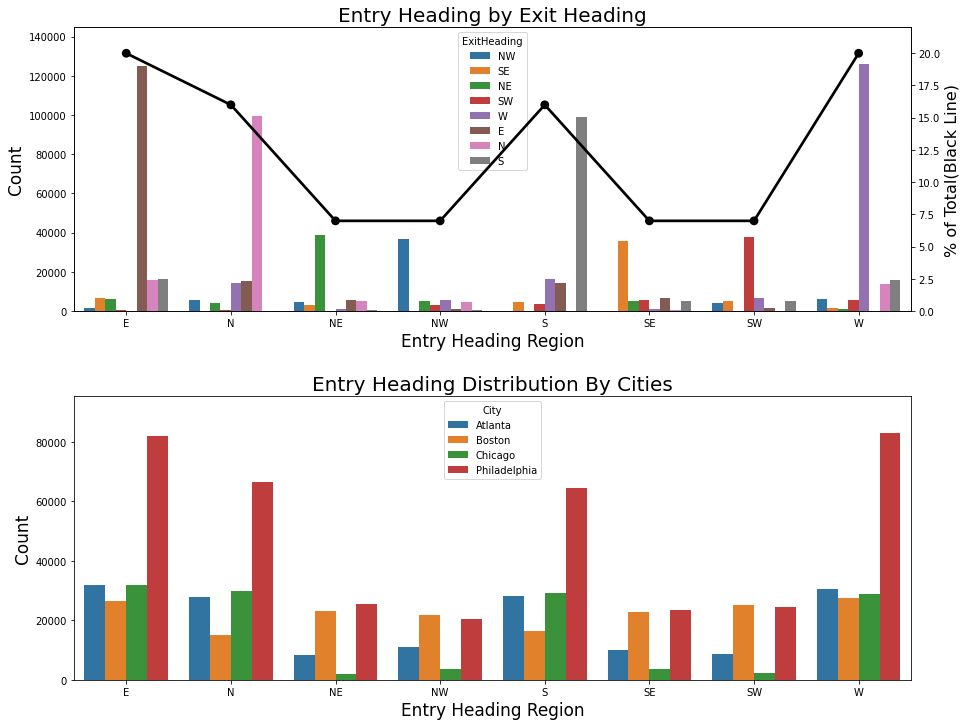

In [13]:
plt.figure(figsize=(15,12))

tmp = round(((df_train.groupby(['EntryHeading'])['RowId'].nunique() / total) * 100)).reset_index()

plt.subplot(211)
g = sns.countplot(x="EntryHeading",
                  data=df_train,
                  order=list(tmp['EntryHeading'].values),
                  hue='ExitHeading', dodge=True)
g.set_title("Entry Heading by Exit Heading", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Entry Heading Region", fontsize=17)
gt = g.twinx()
gt = sns.pointplot(x='EntryHeading', y='RowId', 
                   data=tmp, order=list(tmp['EntryHeading'].values),
                   color='black', legend=False)
gt.set_ylim(0, tmp['RowId'].max()*1.1)
gt.set_ylabel("% of Total(Black Line)", fontsize=16)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)

g.set_ylim(0, max(sizes) * 1.15)

plt.subplot(212)
g1 = sns.countplot(x="EntryHeading", order=list(tmp['EntryHeading'].values), 
                   data=df_train, hue='City')
g1.set_title("Entry Heading Distribution By Cities", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Entry Heading Region", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)

g1.set_ylim(0, max(sizes) * 1.15)

plt.subplots_adjust(hspace = 0.3)

plt.show()